In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from rdkit import Chem
from rdkit.Chem import Descriptors
from lime import lime_tabular
import warnings
from tqdm import tqdm
from transformers import BertModel, BertTokenizer
warnings.filterwarnings('ignore')


In [51]:

# Load data
posDF = pd.read_csv(r"C:\Users\advik\Downloads\bio project\PositiveSequences.csv")
allDataDF = pd.read_csv(r'C:\Users\advik\Downloads\bio project\nlp_data.csv')
dadp=allDataDF['DADP ID']
# Process data for Method 1 (Physicochemical Properties)
allDataDF = allDataDF.set_index(allDataDF['DADP ID'])
posDF = posDF.set_index(posDF['DADP ID'])
posID_List = posDF["DADP ID"].tolist()
negDF = allDataDF.drop(posID_List)

invalid_chars = "/"
negDF = negDF[~negDF['Bioactive sequence'].str.contains(invalid_chars)]
posDF = posDF[~posDF['Bioactive sequence'].str.contains(invalid_chars)]

0       SP_P86816
1       SP_P86817
2       SP_P86812
3       SP_P86813
4       SP_P86814
          ...    
2566      SP_2596
2567      SP_2704
2568      SP_2705
2569      SP_2743
2570      SP_2742
Name: DADP ID, Length: 2571, dtype: object


In [3]:


def calculate_physicochemical_properties(sequence):
    analyzed_seq = ProteinAnalysis(sequence)
    properties = {
        'MolecularWeight': analyzed_seq.molecular_weight(),
        'IsoelectricPoint': analyzed_seq.isoelectric_point(),
        'Aromaticity': analyzed_seq.aromaticity(),
        'InstabilityIndex': analyzed_seq.instability_index(),
        'Hydrophobicity': analyzed_seq.gravy(),
        'ChargeAtPH7': analyzed_seq.charge_at_pH(7.0)
    }
    return properties

def calculate_rdkit_descriptors(sequence):
    mol = Chem.MolFromSequence(sequence)
    properties = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'BalabanJ': Descriptors.BalabanJ(mol),
        'BertzCT': Descriptors.BertzCT(mol),
        'Chi0v': Descriptors.Chi0v(mol),
        'Chi1v': Descriptors.Chi1v(mol),
        'HallKierAlpha': Descriptors.HallKierAlpha(mol),
        'Kappa1': Descriptors.Kappa1(mol),
        'Kappa2': Descriptors.Kappa2(mol),
        'Kappa3': Descriptors.Kappa3(mol)
    }
    return properties

def calculate_all_properties(sequence):
    physico_props = calculate_physicochemical_properties(sequence)
    rdkit_props = calculate_rdkit_descriptors(sequence)
    all_props = {**physico_props, **rdkit_props}
    return all_props



In [67]:


posDF['Properties'] = posDF['Bioactive sequence'].apply(calculate_all_properties)
negDF['Properties'] = negDF['Bioactive sequence'].apply(calculate_all_properties)

pos_properties = pd.DataFrame(posDF['Properties'].tolist(), index=posDF.index)
neg_properties = pd.DataFrame(negDF['Properties'].tolist(), index=negDF.index)
pos_properties['Value'] = 1
neg_properties['Value'] = 0

all_properties = pd.concat([pos_properties, neg_properties])


           MolecularWeight  IsoelectricPoint  Aromaticity  InstabilityIndex  \
DADP ID                                                                       
SP_P31107        3181.6835          9.701025     0.030303          7.272727   
SP_2643          2279.6794          9.703153     0.043478        -12.986957   
SP_2644          2293.7060          9.703153     0.043478         -4.613043   
SP_2645          2266.6807          9.703153     0.043478         -4.613043   
SP_2646          1583.9103          8.750052     0.000000         10.800000   
...                    ...               ...          ...               ...   
SP_2852          1405.7470         10.002350     0.076923         16.907692   
SP_2853          2124.3526          4.651158     0.166667         37.416667   
SP_2854          2138.4670          8.045284     0.150000         72.685000   
SP_2855          2076.4408          9.820679     0.117647         50.894118   
SP_Q09022        7235.6096          8.884082     0.0

In [5]:

# Prepare data for Method 1
X1 = all_properties.drop('Value', axis=1)
y1 = all_properties['Value']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=0)

scaler1 = StandardScaler()
X1_train = scaler1.fit_transform(X1_train)
X1_test = scaler1.transform(X1_test)

In [6]:


# Process data for Method 2 (One-hot Encoding)
allDataDF = allDataDF.reset_index(drop=True)
posDF = posDF.reset_index(drop=True)
negDF = negDF.reset_index(drop=True)

posDF['Bioactive sequence'] = (posDF['Bioactive sequence'].str.upper())
negDF['Bioactive sequence'] = (negDF['Bioactive sequence'].str.upper())

posDF['TruncSequence'] = (posDF['Bioactive sequence'].str.slice(0,22))
negDF['TruncSequence'] = (negDF['Bioactive sequence'].str.slice(0,22))

posDF['ModSequence'] = (posDF['TruncSequence'].str.pad(22,"right","#"))
negDF['ModSequence'] = (negDF['TruncSequence'].str.pad(22,"right","#"))

posDF['Value'] = 1
negDF['Value'] = 0

allDataDF2 = pd.concat([posDF, negDF])

alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ#/ '
char_to_int = dict((c, i) for i, c in enumerate(alphabet))

def one_hot_encode_sequence(sequence):
    integer_encoded = [char_to_int[char] for char in sequence]
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return [item for sublist in onehot_encoded for item in sublist]

allDataDF2['EncodedX'] = allDataDF2['ModSequence'].apply(one_hot_encode_sequence)


In [7]:
# Prepare data for Method 2
X2 = np.array(list(allDataDF2['EncodedX']))
y2 = allDataDF2['Value']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=0)

In [8]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "SVC": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000)
}


In [9]:
models1 = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "SVC": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000)
}


In [10]:
# Function to train models and return results
def train_and_evaluate_models(X_train, y_train, X_test, y_test, models):
    results = []
    trained_models = {}
    
    for model_name, model in models.items():
        scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_weighted', 'roc_auc']
        scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)

        fit_time = scores['fit_time'].mean()
        score_time = scores['score_time'].mean()
        accuracy = scores['test_accuracy'].mean()
        precision = scores['test_precision_macro'].mean()
        recall = scores['test_recall_macro'].mean()
        f1 = scores['test_f1_weighted'].mean()
        roc_auc = scores['test_roc_auc'].mean()

        model.fit(X_train, y_train)
        
        results.append({
            'Model': model_name,
            'Fitting time': fit_time,
            'Scoring time': score_time,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1_score': f1,
            'AUC_ROC': roc_auc
        })

        trained_models[model_name] = model

    return pd.DataFrame(results).sort_values(by='Accuracy', ascending=False), trained_models

In [11]:
# Train and evaluate models for Method 1
results_method1, trained_models_method1 = train_and_evaluate_models(X1_train, y1_train, X1_test, y1_test, models)
print("Model performance for Method 1 (Physicochemical Properties):")
print(results_method1)



Model performance for Method 1 (Physicochemical Properties):
                             Model  Fitting time  Scoring time  Accuracy  \
3                    Random Forest      0.782243      0.031093  0.798240   
1                    Decision Tree      0.042854      0.011552  0.765595   
6              K-Nearest Neighbors      0.005826      0.071852  0.728092   
8                   Neural Network      4.147815      0.012571  0.724165   
2                              SVC      0.721747      0.157400  0.683710   
4     Linear Discriminant Analysis      0.024453      0.011765  0.678848   
0              Logistic Regression      0.028228      0.010829  0.634486   
5  Quadratic Discriminant Analysis      0.011597      0.010319  0.627165   
7                            Bayes      0.004560      0.016464  0.581364   

   Precision    Recall  F1_score   AUC_ROC  
3   0.789130  0.765835  0.793751  0.874442  
1   0.747185  0.747293  0.765434  0.749992  
6   0.707296  0.707269  0.727915  0.794130 

In [12]:
# Train and evaluate models for Method 2
results_method2, trained_models_method2 = train_and_evaluate_models(X2_train, y2_train, X2_test, y2_test, models1)
print("\nModel performance for Method 2 (One-hot Encoding):")
print(results_method2)

# Combine results for plotting
combined_results = pd.concat([results_method1.assign(Method='Physicochemical Properties'), results_method2.assign(Method='One-hot Encoding')])


Model performance for Method 2 (One-hot Encoding):
                             Model  Fitting time  Scoring time  Accuracy  \
3                    Random Forest      0.708552      0.032614  0.794355   
8                   Neural Network      8.283408      0.019665  0.782160   
1                    Decision Tree      0.084575      0.013751  0.780726   
2                              SVC      4.017630      0.656406  0.754396   
6              K-Nearest Neighbors      0.001396      0.124998  0.750504   
5  Quadratic Discriminant Analysis      0.974534      0.049241  0.739761   
0              Logistic Regression      0.130932      0.018666  0.730026   
4     Linear Discriminant Analysis      0.459537      0.017082  0.706627   
7                            Bayes      0.020387      0.025719  0.550663   

   Precision    Recall  F1_score   AUC_ROC  
3   0.781231  0.769084  0.791822  0.877826  
8   0.765415  0.765211  0.781851  0.840861  
1   0.764147  0.766118  0.781081  0.782127  
2   0.7

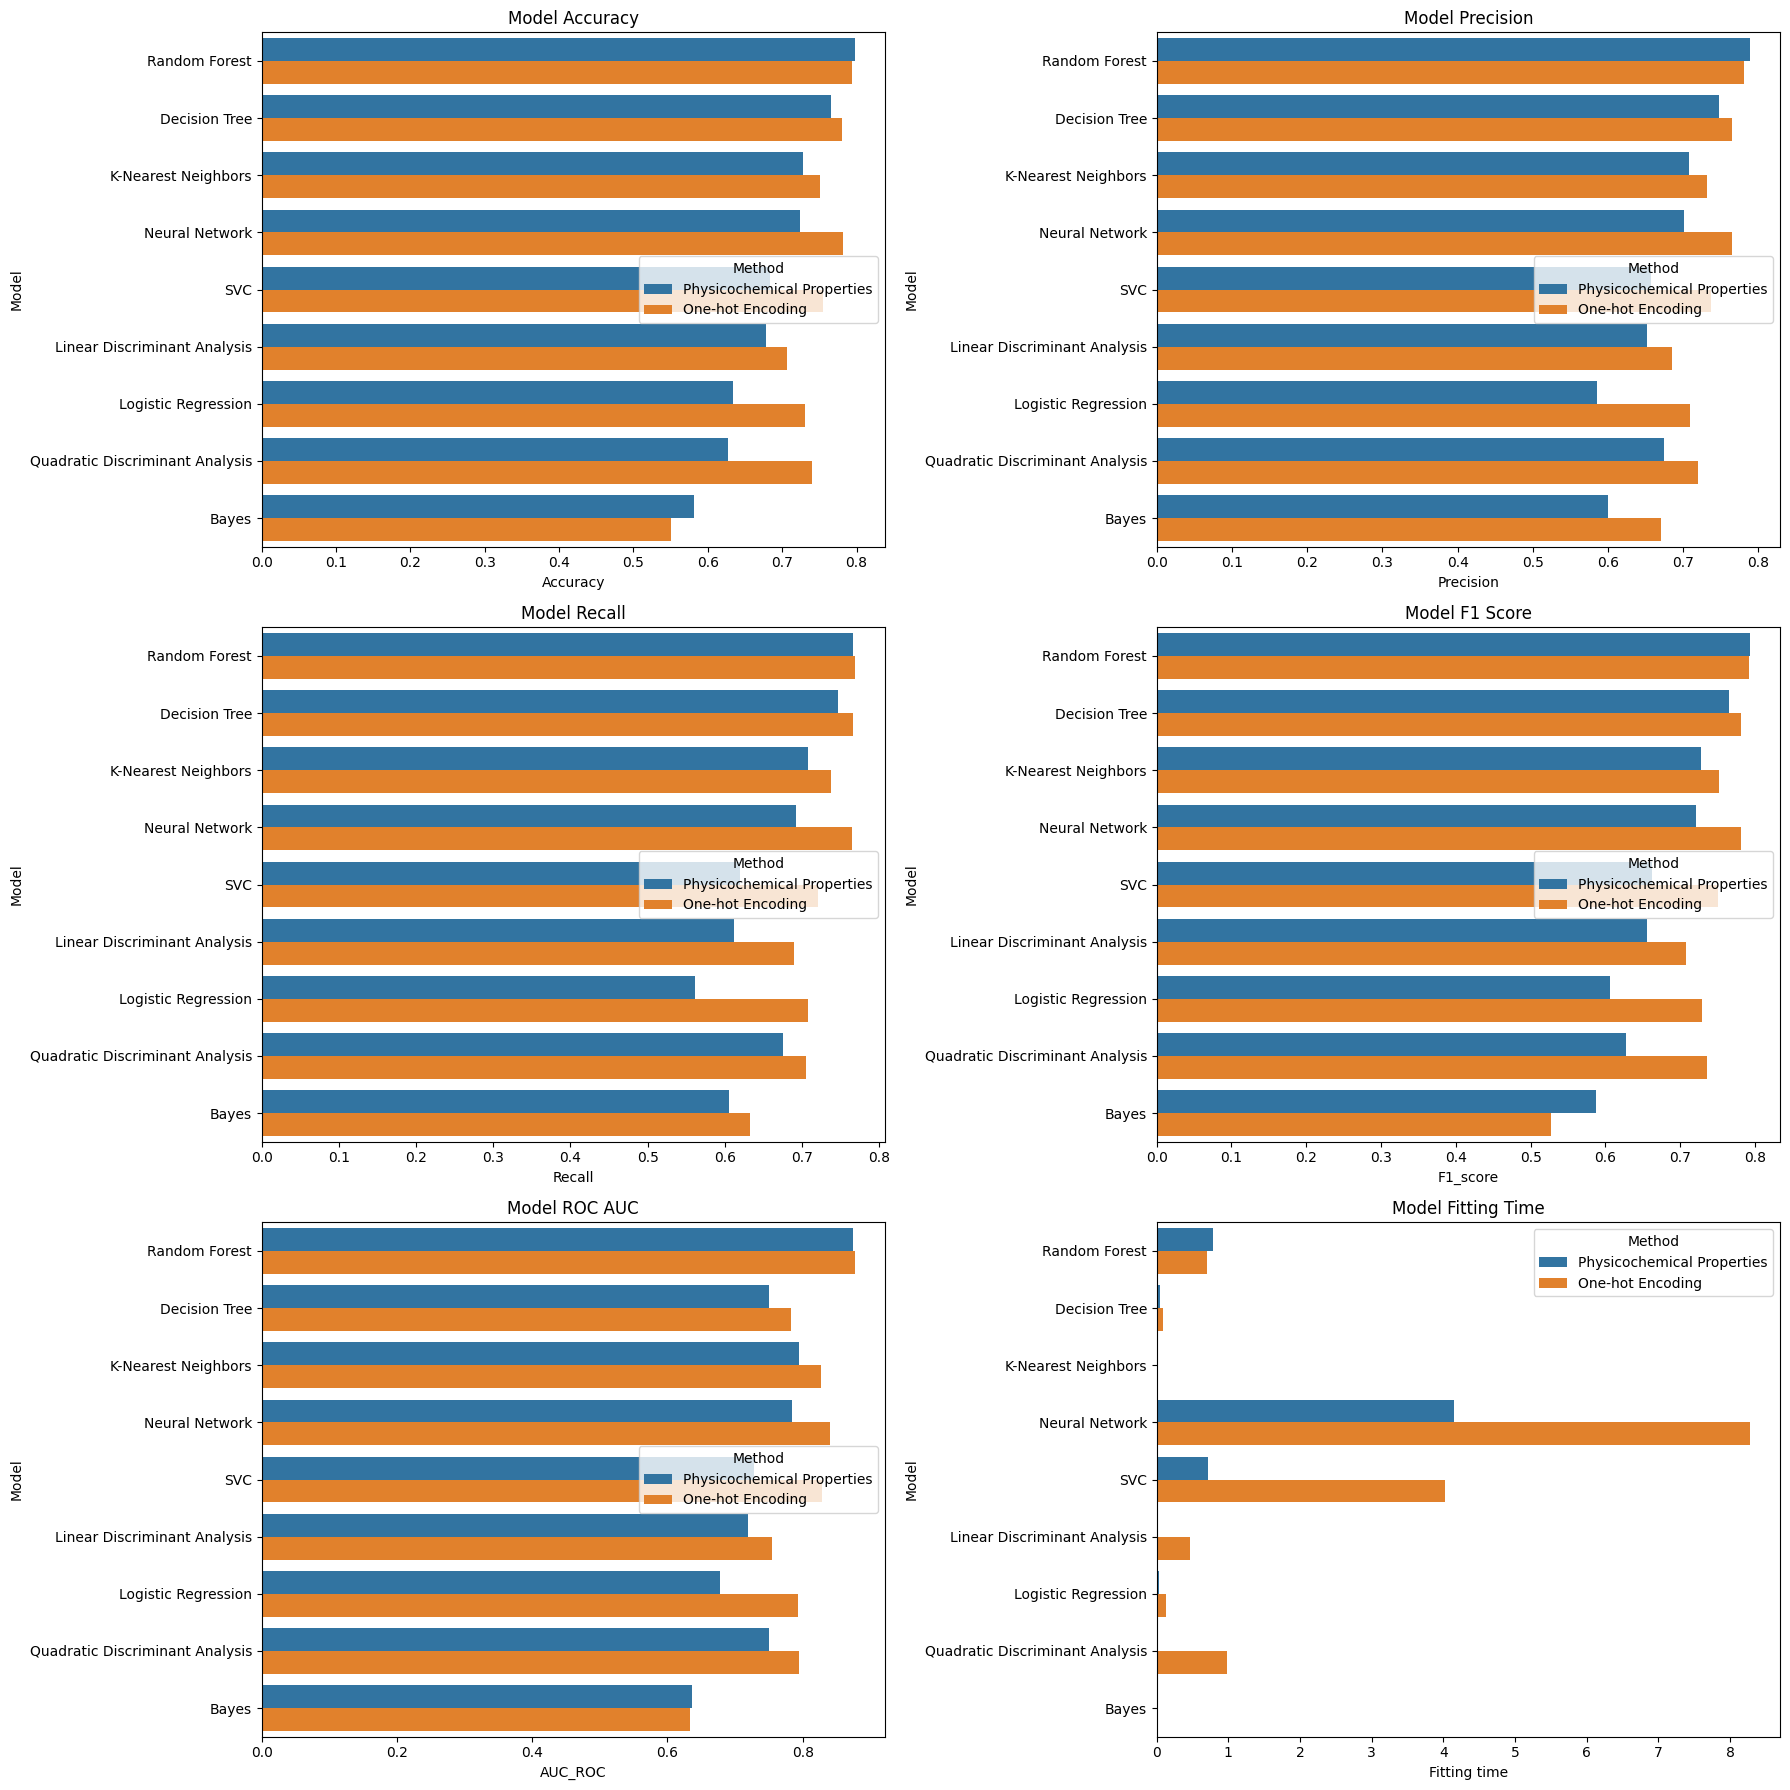

In [13]:
# Plot results
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

sns.barplot(x='Accuracy', y='Model', hue='Method', data=combined_results, ax=axes[0, 0])
axes[0, 0].set_title('Model Accuracy')

sns.barplot(x='Precision', y='Model', hue='Method', data=combined_results, ax=axes[0, 1])
axes[0, 1].set_title('Model Precision')

sns.barplot(x='Recall', y='Model', hue='Method', data=combined_results, ax=axes[1, 0])
axes[1, 0].set_title('Model Recall')

sns.barplot(x='F1_score', y='Model', hue='Method', data=combined_results, ax=axes[1, 1])
axes[1, 1].set_title('Model F1 Score')

sns.barplot(x='AUC_ROC', y='Model', hue='Method', data=combined_results, ax=axes[2, 0])
axes[2, 0].set_title('Model ROC AUC')

sns.barplot(x='Fitting time', y='Model', hue='Method', data=combined_results, ax=axes[2, 1])
axes[2, 1].set_title('Model Fitting Time')

plt.tight_layout()
plt.show()

In [14]:
# Function to predict antimicrobial property using Method 1
def predict_method1(sequence, models, scaler):
    properties = calculate_all_properties(sequence)
    prop_values = scaler.transform([list(properties.values())])
    results = {}
    for name, model in models.items():
        prediction = model.predict(prop_values)
        results[name] = 'Antimicrobial' if prediction[0] == 1 else 'Non-antimicrobial'
    return results

# Example prediction
sequence = 'GLWSKIKEVGKEAAKAAAKAAG'

# Predictions using Method 1
predictions1 = predict_method1(sequence, trained_models_method1, scaler1)
print("\nPredictions for Method 1 (Physicochemical Properties):")
for model_name, prediction in predictions1.items():
    print(f"{model_name}: {prediction}")

# LIME explanations
explainer1 = lime_tabular.LimeTabularExplainer(X1_train, feature_names=X1.columns, class_names=['Non-antimicrobial', 'Antimicrobial'], discretize_continuous=True)
# Explain prediction for Method 1
lime_explanation1 = explainer1.explain_instance(scaler1.transform([list(calculate_all_properties(sequence).values())])[0], trained_models_method1["Random Forest"].predict_proba)
lime_explanation1.show_in_notebook()


Predictions for Method 1 (Physicochemical Properties):
Logistic Regression: Non-antimicrobial
Decision Tree: Non-antimicrobial
SVC: Non-antimicrobial
Random Forest: Non-antimicrobial
Linear Discriminant Analysis: Non-antimicrobial
Quadratic Discriminant Analysis: Antimicrobial
K-Nearest Neighbors: Antimicrobial
Bayes: Antimicrobial
Neural Network: Non-antimicrobial


In [15]:





# Function to predict antimicrobial property using Method 2
def predict_method2(sequence, models):
    sequence = sequence.upper().ljust(22, '#')[:22]
    integer_encoded = [char_to_int[char] for char in sequence]
    onehot_encoded = np.ravel([[0 if i != val else 1 for i in range(len(char_to_int))] for val in integer_encoded])
    results = {}
    for name, model in models.items():
        prediction = model.predict([onehot_encoded])
        results[name] = 'Antimicrobial' if prediction[0] == 1 else 'Non-antimicrobial'
    return results

# Predictions using Method 2
predictions2 = predict_method2(sequence, trained_models_method2)
print("\nPredictions for Method 2 (One-hot Encoding):")
for model_name, prediction in predictions2.items():
    print(f"{model_name}: {prediction}")

explainer2 = lime_tabular.LimeTabularExplainer(X2_train, feature_names=[f'Feature {i}' for i in range(X2_train.shape[1])], class_names=['Non-antimicrobial', 'Antimicrobial'], discretize_continuous=True)
# Explain prediction for Method 2
lime_explanation2 = explainer2.explain_instance(np.array(one_hot_encode_sequence(sequence)), trained_models_method2["Random Forest"].predict_proba)
lime_explanation2.show_in_notebook()



Predictions for Method 2 (One-hot Encoding):
Logistic Regression: Non-antimicrobial
Decision Tree: Antimicrobial
SVC: Antimicrobial
Random Forest: Antimicrobial
Linear Discriminant Analysis: Non-antimicrobial
Quadratic Discriminant Analysis: Antimicrobial
K-Nearest Neighbors: Antimicrobial
Bayes: Antimicrobial
Neural Network: Antimicrobial


In [24]:
def get_bert_embeddings(sequence, tokenizer, model):
    inputs = tokenizer(sequence, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()
allDataDF = pd.concat([posDF, negDF])
sequences = allDataDF['Bioactive sequence'].tolist()
labels = allDataDF['Value'].tolist()
# Load BioBERT model and tokenizer
print("Loading BioBERT model and tokenizer...")
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Get embeddings for each sequence
print("Generating embeddings for sequences...")
embeddings = []
for seq in tqdm(sequences, desc="Embedding sequences"):
    embedding = get_bert_embeddings(seq, tokenizer, model)
    embeddings.append(embedding)
    # Print features for the first 5 sequences
    if len(embeddings) <= 5:
        print(f"Sequence: {seq}")
        print(f"Embedding shape: {embedding.shape}")
        print(f"Embedding: {embedding}")

X = np.array(embeddings).squeeze()
print(X)
y = np.array(labels)

# Split data
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define models
print("Defining models...")
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "SVC": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

# Function to train models and return results
def train_and_evaluate_models(X_train, y_train, X_test, y_test, models):
    results = []
    trained_models = {}
    
    for model_name, model in tqdm(models.items(), desc="Training models"):
        print(f"Training {model_name}...")
        scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_weighted', 'roc_auc']
        scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)

        fit_time = scores['fit_time'].mean()
        score_time = scores['score_time'].mean()
        accuracy = scores['test_accuracy'].mean()
        precision = scores['test_precision_macro'].mean()
        recall = scores['test_recall_macro'].mean()
        f1 = scores['test_f1_weighted'].mean()
        roc_auc = scores['test_roc_auc'].mean()

        model.fit(X_train, y_train)
        
        results.append({
            'Model': model_name,
            'Fitting time': fit_time,
            'Scoring time': score_time,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1_score': f1,
            'AUC_ROC': roc_auc
        })

        trained_models[model_name] = model

    return pd.DataFrame(results).sort_values(by='Accuracy', ascending=False), trained_models

# Train and evaluate models
print("Training and evaluating models...")
results, trained_models = train_and_evaluate_models(X_train, y_train, X_test, y_test, models)
print("Model performance using BioBERT embeddings:")
print(results)

# Function to predict antimicrobial property using BioBERT embeddings
def predict(sequence, models, tokenizer, model):
    print(f"Predicting for sequence: {sequence}")
    embedding = get_bert_embeddings(sequence, tokenizer, model)
    print(embedding)
    results = {}
    for name, model in models.items():
        prediction = model.predict(embedding)
        results[name] = 'Antimicrobial' if prediction[0] == 1 else 'Non-antimicrobial'
    return results

# Example prediction
sequence = 'GLWSKIKEVGKEAAKAAAKAAG'
predictions = predict(sequence, trained_models, tokenizer, model)
print("\nPredictions using BioBERT embeddings:")
for model_name, prediction in predictions.items():
    print(f"{model_name}: {prediction}")

# LIME explanations
print("Generating LIME explanations...")
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=[f'Feature {i}' for i in range(X_train.shape[1])], class_names=['Non-antimicrobial', 'Antimicrobial'], discretize_continuous=True)
lime_explanation = explainer.explain_instance(X_test[0], trained_models["Random Forest"].predict_proba)
lime_explanation.show_in_notebook()


Loading BioBERT model and tokenizer...
Generating embeddings for sequences...


Embedding sequences:   0%|                                                            | 1/2566 [00:00<05:31,  7.74it/s]

Sequence: GLWSKIKEVGKEAAKAAAKAAGKAALGAVSEAV
Embedding shape: (1, 768)
Embedding: [[-1.64003409e-02 -4.82710510e-01  2.49254555e-01 -1.09041380e-02
   7.28634894e-01 -6.47612751e-01  5.33651933e-02  6.01541884e-02
   1.70116290e-01  1.52809873e-01  6.76362962e-02 -3.91306877e-01
   2.00200170e-01 -1.46960109e-01 -2.70447642e-01  1.64351575e-02
  -3.26772660e-01 -5.08496761e-01 -6.19464889e-02 -2.41161324e-02
  -2.76165307e-01 -1.97354943e-01 -1.28901646e-01  6.33836761e-02
  -7.28787035e-02  9.17148683e-03 -1.29213050e-01  2.32727125e-01
  -3.41059491e-02  5.04042029e-01 -1.14261426e-01 -3.74896735e-01
  -3.62805247e-01 -8.44919980e-01  1.53892905e-01  1.49310201e-01
  -3.13910916e-02 -1.67167813e-01  2.06563830e-01 -7.79478401e-02
   2.59182304e-01  2.83368021e-01  9.26770031e-01  9.09246728e-02
   2.39800140e-01 -2.97584422e-02 -3.81289199e-02 -4.01842356e-01
   6.95645362e-02  4.24234152e-01 -2.79195487e-01  3.44893396e-01
   4.80712652e-02  2.03084499e-01  3.26647237e-02 -7.62905851

Embedding sequences:   0%|                                                            | 2/2566 [00:00<05:22,  7.95it/s]

Sequence: GLKDIFKAGLGSLVKGIAAHVAN
Embedding shape: (1, 768)
Embedding: [[-2.39010490e-02 -2.33540326e-01  1.92510039e-01  8.32312256e-02
   5.57904661e-01 -4.47531551e-01 -4.32847887e-02  1.32698268e-01
  -1.58001319e-01  9.90876406e-02  2.84191296e-02 -3.57559659e-02
   5.81406429e-02  1.83091030e-01 -4.68541980e-01  3.13818790e-02
  -1.27158090e-01 -6.13479674e-01 -5.09168744e-01 -3.16542953e-01
   4.81944382e-02 -3.91466558e-01  7.07068667e-02  4.50688124e-01
  -2.03467667e-01 -1.62821859e-01  1.75910100e-01  8.89525265e-02
   5.68361357e-02  2.70916879e-01  2.48028174e-01  1.85280979e-01
  -3.51151615e-01 -3.62523377e-01 -7.12660253e-02  2.77917862e-01
  -2.32048437e-01  4.63072248e-02  4.03412968e-01 -8.39722604e-02
   5.36641181e-01  3.65184158e-01  2.13804573e-01 -2.58796424e-01
   8.79949238e-03 -7.94422105e-02 -1.00306213e-01 -6.67049587e-01
  -3.27729404e-01  5.53718090e-01 -2.02324882e-01  5.06474301e-02
  -1.10692140e-02  1.97820410e-01 -1.38164759e-01  2.44680531e-02
  -4.

Embedding sequences:   0%|                                                            | 3/2566 [00:00<06:00,  7.10it/s]

Sequence: GLKEIFKAGLGSLVKGIAAHVAN
Embedding shape: (1, 768)
Embedding: [[ 8.61636642e-03 -1.99447215e-01  1.49483770e-01  1.64424866e-01
   5.69961667e-01 -4.30806249e-01 -4.15065587e-02  1.20532125e-01
  -2.02838749e-01  1.16509594e-01  1.02735043e-01 -1.48840353e-01
   2.02499144e-02  2.52398551e-01 -3.77115309e-01 -1.25083551e-02
  -1.26747936e-01 -5.88561594e-01 -4.99318838e-01 -2.88136244e-01
   7.85932541e-02 -3.77263844e-01  5.83143905e-04  4.66973692e-01
  -1.96470752e-01 -1.46044835e-01  1.70818672e-01  4.72114906e-02
   1.32209733e-01  2.13297874e-01  2.78207302e-01  1.44765139e-01
  -3.70182961e-01 -2.96979338e-01 -2.84897219e-02  2.51754463e-01
  -2.37513468e-01  7.59145170e-02  3.88892472e-01 -2.92096641e-02
   4.81462836e-01  3.93662423e-01  2.09847748e-01 -2.18894869e-01
   3.60136330e-02 -5.14335707e-02 -1.55910969e-01 -5.96213698e-01
  -3.13494205e-01  5.46314418e-01 -2.90993541e-01  1.10304780e-01
  -4.41074371e-06  1.68431610e-01 -1.47989720e-01  5.08777238e-02
  -4.

Embedding sequences:   0%|                                                            | 4/2566 [00:00<05:53,  7.26it/s]

Sequence: GLKEIFKAGLGSLVKGIAAHVAS
Embedding shape: (1, 768)
Embedding: [[ 2.99375374e-02 -2.49088258e-01  1.55520067e-01  1.74195647e-01
   5.87186933e-01 -4.58949417e-01 -3.88671458e-02  9.23771262e-02
  -1.90668911e-01  1.49446994e-01  1.21860221e-01 -1.58862278e-01
  -1.04883816e-02  2.39455745e-01 -3.71506095e-01 -5.15804775e-02
  -1.47714913e-01 -6.21717453e-01 -5.28164089e-01 -2.76076972e-01
   6.71040490e-02 -4.00381893e-01 -3.52564529e-02  4.63665187e-01
  -1.86297059e-01 -1.41146690e-01  2.05353335e-01  8.67674202e-02
   1.38288543e-01  2.23974988e-01  2.73471385e-01  1.11061677e-01
  -3.19906533e-01 -3.19310009e-01 -4.41194810e-02  2.60255337e-01
  -2.22093210e-01  2.59023644e-02  4.13999349e-01 -1.94610413e-02
   4.73784715e-01  3.73358488e-01  1.94509536e-01 -2.04910874e-01
   3.75640318e-02 -1.70986578e-02 -1.23039991e-01 -6.41774178e-01
  -3.57744545e-01  5.16581714e-01 -2.58230656e-01  1.44516066e-01
   4.15183604e-04  1.34815753e-01 -1.30303055e-01  3.42040695e-02
  -4.

Embedding sequences: 100%|█████████████████████████████████████████████████████████| 2566/2566 [05:22<00:00,  7.95it/s]


[[-0.01640034 -0.4827105   0.24925455 ...  0.1259765  -0.35932308
  -0.59546506]
 [-0.02390105 -0.23354033  0.19251004 ...  0.21376953 -0.19078742
  -0.42928624]
 [ 0.00861637 -0.19944721  0.14948377 ...  0.15694927 -0.2232124
  -0.4371181 ]
 ...
 [ 0.1672608  -0.2234647   0.14960316 ...  0.12826489  0.04223094
  -0.1265388 ]
 [ 0.26691902 -0.6658726   0.25356385 ...  0.23776186 -0.38369533
  -0.4133269 ]
 [ 0.0466821  -0.38446936  0.12093671 ...  0.09963294 -0.5619745
  -0.33068216]]
Splitting data into training and testing sets...
Defining models...
Training and evaluating models...


Training models:   0%|                                                                           | 0/9 [00:00<?, ?it/s]

Training Logistic Regression...


Training models:  11%|███████▍                                                           | 1/9 [00:02<00:22,  2.79s/it]

Training Decision Tree...


Training models:  22%|██████████████▉                                                    | 2/9 [00:17<01:08,  9.85s/it]

Training SVC...


Training models:  33%|██████████████████████▎                                            | 3/9 [01:05<02:43, 27.25s/it]

Training Random Forest...


Training models:  44%|█████████████████████████████▊                                     | 4/9 [01:35<02:21, 28.36s/it]

Training Linear Discriminant Analysis...


Training models:  56%|█████████████████████████████████████▏                             | 5/9 [01:39<01:18, 19.53s/it]

Training Quadratic Discriminant Analysis...


Training models:  67%|████████████████████████████████████████████▋                      | 6/9 [01:49<00:49, 16.45s/it]

Training K-Nearest Neighbors...


Training models:  78%|████████████████████████████████████████████████████               | 7/9 [01:51<00:23, 11.64s/it]

Training Bayes...


Training models:  89%|███████████████████████████████████████████████████████████▌       | 8/9 [01:52<00:08,  8.12s/it]

Training Neural Network...


Training models: 100%|███████████████████████████████████████████████████████████████████| 9/9 [02:56<00:00, 19.62s/it]


Model performance using BioBERT embeddings:
                             Model  Fitting time  Scoring time  Accuracy  \
3                    Random Forest      4.637875      0.034724  0.783619   
8                   Neural Network      9.601167      0.012817  0.775349   
0              Logistic Regression      0.400812      0.018331  0.736361   
1                    Decision Tree      2.422267      0.010352  0.736359   
6              K-Nearest Neighbors      0.005210      0.091098  0.724181   
4     Linear Discriminant Analysis      0.618640      0.014131  0.715393   
2                              SVC      4.510309      0.679993  0.671534   
5  Quadratic Discriminant Analysis      1.621981      0.039747  0.635966   
7                            Bayes      0.013973      0.029354  0.601340   

   Precision    Recall  F1_score   AUC_ROC  
3   0.791301  0.729991  0.770056  0.860705  
8   0.758022  0.754983  0.774514  0.831732  
0   0.716053  0.699725  0.731023  0.790172  
1   0.715869  0

In [115]:
embeddings_df = pd.DataFrame(X)
embeddings_df=embeddings_df.join(dadp)
embeddings_df=embeddings_df.set_index(embeddings_df['DADP ID'])
embeddings_df=embeddings_df.drop(columns=['DADP ID'])

df_combined = embeddings_df.join(all_properties, lsuffix='_left', rsuffix='_right')

sorted_df = df_combined.sort_values(by='Value', ascending=False)
allDataDF2['EncodedX'] = allDataDF2['ModSequence'].apply(one_hot_encode_sequence)
e=allDataDF2.set_index(allDataDF2['DADP ID'])
e=e.drop(columns=['DADP ID','Entry Name','Uniprot code','Species','Sequence length','signal sequence','Bioactive sequence','Properties','TruncSequence','ModSequence'])
t=e.join(sorted_df,lsuffix='_left', rsuffix='_right').drop(columns=['Value_right']).rename(columns={'Value_left':"Value"})
display(t)

X1 = t.drop(columns=['Value','EncodedX'], axis=1).values  # Assuming X1 are features from all_properties
display(X1)
y1 = t['Value'].values
X2 = np.array(list(t['EncodedX']))
display(X2)
X= np.concatenate((X1, X2), axis=1)
display(X)
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=0)

scaler1 = StandardScaler()
X1_train = scaler1.fit_transform(X1_train)
X1_test = scaler1.transform(X1_test)

Value                                           EncodedX         0  \
DADP ID                                                                         
SP_P31107      1  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ... -0.001182   
SP_2643        1  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ... -0.001826   
SP_2644        1  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  0.140125   
SP_2645        1  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ... -0.146020   
SP_2646        1  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  0.155032   
...          ...                                                ...       ...   
SP_2852        0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  0.060683   
SP_2853        0  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  0.128170   
SP_2854        0  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  0.029537   
SP_2855        0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... -0.028244   
SP_Q09022      0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  0.130246   

                  1         2         3         4         5         6  \
DADP ID                                                                 
SP_P31107 -0.282302  0.255522  0.092411  0.545212 -0.485099 -0.214640   
SP_2643   -0.274118  0.242749  0.098840  0.349255 -0.398265 -0.271011   
SP_2644   -0.321496  0.354899  0.193492  0.550035 -0.379097 -0.081231   
SP_2645   -0.259933  0.370332  0.093711  0.653342 -0.539562 -0.012694   
SP_2646   -0.349015  0.444967  0.292042  0.449536 -0.402997 -0.109551   
...             ...       ...       ...       ...       ...       ...   
SP_2852   -0.289950  0.203521  0.242106  0.258104 -0.337407 -0.061740   
SP_2853   -0.398235  0.226522 -0.002301  0.296549 -0.446349  0.055020   
SP_2854   -0.309721  0.236486 -0.118356  0.313986 -0.481001 -0.220321   
SP_2855   -0.011733  0.247998 -0.059405  0.271358 -0.307524 -0.261113   
SP_Q09022 -0.065193 -0.054381 -0.247074 -0.284014 -0.471134 -0.122525   

                  7  ...  NumHDonors  NumHAcceptors  BalabanJ       BertzCT  \
DADP ID              ...                                                      
SP_P31107 -0.078176  ...        46.0           45.0  2.195969   7612.627585   
SP_2643    0.114062  ...        31.0           31.0  2.246811   5191.774736   
SP_2644   -0.011475  ...        31.0           31.0  2.254177   5211.853178   
SP_2645    0.027259  ...        31.0           31.0  2.253657   5096.168912   
SP_2646   -0.022859  ...        22.0           22.0  6.186024   3100.024844   
...             ...  ...         ...            ...       ...           ...   
SP_2852   -0.046518  ...        18.0           19.0  3.276060   2766.535116   
SP_2853   -0.120341  ...        26.0           26.0  0.992706   5867.905389   
SP_2854    0.162137  ...        26.0           29.0  0.884764   5233.121472   
SP_2855   -0.044870  ...        30.0           28.0  1.659505   4729.413175   
SP_Q09022  0.248405  ...       111.0          112.0  2.570045  18204.737165   

                Chi0v       Chi1v  HallKierAlpha      Kappa1      Kappa2  \
DADP ID                                                                    
SP_P31107  131.799954   75.452403         -20.68  199.359058  105.101422   
SP_2643     95.319148   54.422594         -15.02  142.034244   74.405793   
SP_2644     96.026255   54.922594         -15.02  143.033879   75.212983   
SP_2645     94.987870   54.392469         -14.53  141.524432   74.738555   
SP_2646     67.476541   37.978223          -9.21  101.790000   52.104489   
...               ...         ...            ...         ...         ...   
SP_2852     59.496327   34.969862          -8.01   88.001112   47.066173   
SP_2853     86.416638   50.512045         -15.99  121.218778   58.255568   
SP_2854     86.425115   51.704602         -13.86  121.347700   60.104035   
SP_2855     85.376209   50.244738         -13.69  125.600865   65.022901   
SP_Q09022  294.537783  172.867436         -40.18  448.837609  240.5

array([[-1.18213182e-03, -2.82302141e-01,  2.55521804e-01, ...,
         1.99359058e+02,  1.05101422e+02,  7.54033185e+01],
       [-1.82636757e-03, -2.74117738e-01,  2.42749408e-01, ...,
         1.42034244e+02,  7.44057931e+01,  5.41378753e+01],
       [ 1.40125483e-01, -3.21495771e-01,  3.54899317e-01, ...,
         1.43033879e+02,  7.52129832e+01,  5.44315417e+01],
       ...,
       [ 2.95370389e-02, -3.09721321e-01,  2.36486062e-01, ...,
         1.21347700e+02,  6.01040348e+01,  3.59613617e+01],
       [-2.82435715e-02, -1.17333001e-02,  2.47997880e-01, ...,
         1.25600865e+02,  6.50229014e+01,  4.38672763e+01],
       [ 1.30246177e-01, -6.51926398e-02, -5.43806218e-02, ...,
         4.48837609e+02,  2.40573549e+02,  1.74977679e+02]])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

array([[-0.00118213, -0.28230214,  0.2555218 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00182637, -0.27411774,  0.24274941, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14012548, -0.32149577,  0.35489932, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.02953704, -0.30972132,  0.23648606, ...,  1.        ,
         0.        ,  0.        ],
       [-0.02824357, -0.0117333 ,  0.24799788, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.13024618, -0.06519264, -0.05438062, ...,  0.        ,
         0.        ,  0.        ]])

In [116]:
models2 = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "SVC": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000)
}


In [117]:
# Train and evaluate models for Method 2
results_method2, trained_models_method2 = train_and_evaluate_models(X2_train, y2_train, X2_test, y2_test, models2)
print("\nModel performance for Method 2 (One-hot Encoding):")
print(results_method2)

# Combine results for plotting
combined_results = pd.concat([results_method1.assign(Method='Physicochemical Properties'), results_method2.assign(Method='One-hot Encoding')])


Training models:   0%|                                                                           | 0/9 [00:00<?, ?it/s]

Training Logistic Regression...


Training models:  11%|███████▍                                                           | 1/9 [00:01<00:08,  1.04s/it]

Training Decision Tree...


Training models:  22%|██████████████▉                                                    | 2/9 [00:01<00:05,  1.33it/s]

Training SVC...


Training models:  33%|██████████████████████▎                                            | 3/9 [00:37<01:41, 16.96s/it]

Training Random Forest...


Training models:  44%|█████████████████████████████▊                                     | 4/9 [00:43<01:01, 12.33s/it]

Training Linear Discriminant Analysis...


Training models:  56%|█████████████████████████████████████▏                             | 5/9 [00:45<00:35,  8.78s/it]

Training Quadratic Discriminant Analysis...


Training models:  67%|████████████████████████████████████████████▋                      | 6/9 [00:52<00:24,  8.03s/it]

Training K-Nearest Neighbors...


Training models:  78%|████████████████████████████████████████████████████               | 7/9 [00:54<00:12,  6.03s/it]

Training Bayes...


Training models:  89%|███████████████████████████████████████████████████████████▌       | 8/9 [00:54<00:04,  4.29s/it]

Training Neural Network...


Training models: 100%|███████████████████████████████████████████████████████████████████| 9/9 [01:44<00:00, 11.60s/it]


Model performance for Method 2 (One-hot Encoding):
                             Model  Fitting time  Scoring time  Accuracy  \
3                    Random Forest      0.751931      0.049227  0.795331   
8                   Neural Network      8.373596      0.016336  0.782160   
1                    Decision Tree      0.060614      0.011990  0.774390   
2                              SVC      3.351019      0.498040  0.754396   
6              K-Nearest Neighbors      0.004278      0.097907  0.750504   
5  Quadratic Discriminant Analysis      0.928414      0.046421  0.739761   
0              Logistic Regression      0.135273      0.015255  0.730026   
4     Linear Discriminant Analysis      0.349117      0.017308  0.706627   
7                            Bayes      0.020526      0.023416  0.550663   

   Precision    Recall  F1_score   AUC_ROC  
3   0.781152  0.773284  0.793481  0.878409  
8   0.766480  0.761778  0.780855  0.840459  
1   0.757416  0.757987  0.774422  0.773862  
2   0.7